# Confidence-aware belief propagation for multimodal data
This notebook runs a demonstration of the belief propagtion (BP) framework initially created for post-disaster damage assessment by Luke Cullen at the University of Cambridge

In [1]:
# Install uncommon package and imprt others
try: import rioxarray
except: 
    %pip install rioxarray

import interactions as it
%cd ../

defaults = it.get_defaults()

/home/jovyan/damage-assessment


Box(children=(Label(value='Please select default inputs: '), Dropdown(layout=Layout(width='max-content'), opti…

In [2]:
inputs = it.input_parameters(defaults)

HTML(value='<b>Label parameters</b>')

Box(children=(Label(value='Ground truth: Shapefile - '), Text(value='./data/2018IEEE_Contest/Phase2/TrainingGT…

Box(children=(Label(value='Label column - '), Text(value='class', layout=Layout(width='max-content'), placehol…

Box(children=(Label(value='Label confidence ($P_{other label}$, $P_{class}$)'), FloatRangeSlider(value=(0.0, 1…

HTML(value='<b>Data Parameters</b>')

Box(children=(Label(value='Enter Data Types:'), Combobox(value='Hyperspectral imagery', layout=Layout(width='m…

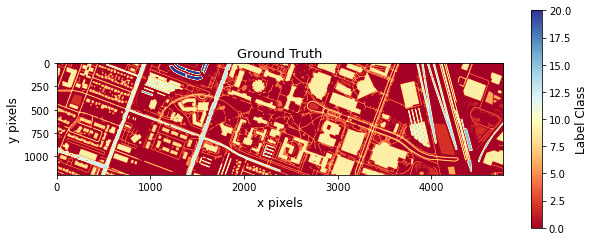

HTML(value='<h3>Model Parameters</h3>')

HTML(value='<b>Node Properties - Sampling occurs if max nodes < input nodes.</b>')

Box(children=(Label(value='Max nodes - '), IntText(value=10000, layout=Layout(width='max-content'), step=1000)…

HTML(value='<b>Edge Properties - Number of neighbours each node is connected to according to input types.</b>'…

Box(children=(IntText(value=2, description='Hyperspectral - ', layout=Layout(width='max-content')), IntText(va…

Box(children=(Label(value='Geographical Edges - '), Checkbox(value=False, indent=False, layout=Layout(width='m…

HTML(value='<b>Class Properties</b>')

HTML(value='Label Classes - [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]')

Box(children=(Label(value='Classes for Model - '), Dropdown(index=19, options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11,…

In [3]:
parameters = it.model_parameters(inputs)

In [13]:
imports = import_data(parameters)

------Checking Coordinate Systems-------
------Finished Checking Coordinate Systems-------
------Importing Data Files---------
Imported./data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix
Imported./data/2018IEEE_Contest/Phase2/Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif


AttributeError: 'str' object has no attribute 'reshape'

In [12]:
import os
import demo.demo_imports as ip
def get_mosaic(target,directory):
    try: 
        print(directory +' is directory - Attempting to mosaic contents.')
        mos = ip.mosaic(target, directory)
        print(directory + ' mosaic complete.')
        return mos
    except: raise ValueError("Failed to mosaic directory")

def reproject_data(v):
    print("------Checking Coordinate Systems-------")
    # Loop through each data type for files
    for i in range(len(v['dataTypes'])):
        # Check if it is a directory - try mosaicing components
        if os.path.isdir(v['postFile'+str(i)]): v['postFile'+str(i)] = ip.get_training_array(ip.mosaic(v['groundTruth'],v['postFile'+str(i)]), v['groundTruth'])
        elif 'preFile'+str(i) in v.keys() and os.path.isdir(v['preFile'+str(i)]): v['preFile'+str(i)] = ip.get_training_array(get_mosaic(v['groundTruth'],v['preFile'+str(i)]), v['groundTruth']) 
                     
        # Check coordinate system is correct - otherwise reproject        
        elif v['crs'] not in ip.get_crs(v['postFile'+str(i)]):
            v['postFile'+str(i)] = ip.conv_coords([v['postFile'+str(i)]], ["data/PostConv"+str(i)+".tif"], v['crs'])[0]
            if v['preFile'+str(i)]: v['preFile'+str(i)] = conv_coords(v['preFile'+str(i)], ["data/PreConv"+str(i)+".tif"], v['crs'])[0]
    print("------Finished Checking Coordinate Systems-------")
    return v


def import_data(v):
    # Retrieve file locations from inputs
    v['dataTypes'] = [i.value.split(' ')[0] for i in v['bxDataTypes'].trait_values()['children'][1:] if len(i.value) > 0]
    for j in range(len(v['dataTypes'])):
        try: v['preFile'+str(j)], v['postFile'+str(j)] = [i.value for i in v['bxfile'+str(j)].trait_values()['children'][1::2]]    
        except KeyError: raise KeyError('Please make sure you have confirmed the data types.')
    for i in v.keys(): globals()[i] = v[i] # Retrieve variables to use
   
    # Reproject Data if necessary
    v = reproject_data(v)
    
    # Import Files
    print("------Importing Data Files---------")
    # Import first data type
    if defs['map']:
        df, crop = ip.img_to_df(postFile0, testPoly, crs=crs)
        if preFile0:
            preDf, _ = ip.img_to_df(preFile0, testPoly, crs=crs)
            df -= preDf

        # Import other data types
        if len(dataTypes) > 1:
            crop.rio.to_raster("croptemp.tif")
            for i in range(1, len(dataTypes)):
                ip.resample_tif(globals()['postFile'+str(i)], testPoly, 'posttemp'+str(i)+'.tif')
                globals()['dataArray'+str(i)] = ip.tif_to_array('posttemp'+str(i)+'.tif', 'resample')
                if globals()['preFile'+str(i)]: 
                    ip.resample_tif(globals()['preFile'+str(i)], testPoly, 'pretemp'+str(i)+'.tif')
                    globals()['dataArray'+str(i)] -= ip.tif_to_array('pretemp'+str(i)+'.tif', 'resample')
            ip.del_file_endings(".", "temp*.tif")
    else: 
        for i in range(len(dataTypes)):
            if type(globals()['postFile'+str(i)]) is str and os.path.isfile(globals()['postFile'+str(i)]):
                ip.raster_to_df(globals()['postFile'+str(i)], cn=dataTypes[i], crop=True, target=groundTruth)
                print('Imported'+globals()['postFile'+str(i)])
            else: ip.arr_to_df(globals()['postFile'+str(i)])
            if globals()['preFile'+str(i)]:
                if type(globals()['preFile'+str(i)]) is str and os.path.isfile(globals()['preFile'+str(i)]):
                    ip.raster_to_df(globals()['preFile'+str(i)], cn=dataTypes[i], crop=True, target=groundTruth)
                    print('Imported'+globals()['preFile'+str(i)])
                else: ip.arr_to_df(globals()['preFile'+str(i)])
    
    # Concatenate data types
    data = df.copy()
    for j in range(1, len(dataTypes)): data[dataTypes[j]]=globals()['dataArray'+str(j)].flatten()
    data.dropna(inplace=True)
    print("------Finished Data Import---------")
    typesUsed = [list(df.columns.values)]
    for j in range(1,len(dataTypes)): typesUsed.append(list(data.columns[[dataTypes[j] in str(i) for i in data.columns]]))

    v.update({'data':data, 'typesUsed':typesUsed})
    return v

In [10]:
os.path.isfile([0,1])

TypeError: stat: path should be string, bytes, os.PathLike or integer, not list

In [7]:
imports['data']

0      1      2  Interferometry
y         x                                             
33.898549 35.508389  259.0  428.0  303.0        0.162670
          35.508394  272.0  443.0  310.0        0.162670
          35.508399  285.0  457.0  318.0        0.161622
          35.508404  281.0  453.0  316.0        0.150546
          35.508409  286.0  459.0  320.0        0.139471
...                    ...    ...    ...             ...
33.888271 35.527211  179.0  329.0  255.0        0.460561
          35.527216  170.0  315.0  249.0        0.457409
          35.527221  161.0  305.0  245.0        0.454256
          35.527226  144.0  285.0  236.0        0.453259
          35.527231  126.0  263.0  226.0        0.453259

[7891225 rows x 4 columns]